In [8]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from six.moves.urllib.request import urlretrieve
import zipfile
import numpy as np
import pandas as pd
import os
import time
import random
import tensorflow as tf
from matplotlib import pylab

## Downloading the data

This code downloads a [BBC dataset](hhttp://mlg.ucd.ie/files/datasets/bbc-fulltext.zip) consisting of news articles published by BBC. 

In [2]:
url = 'http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip'


def download_data(url, data_dir):
    """Download a file if not present, and make sure it's the right size."""
    
    # Create the data directory if not exist
    os.makedirs(data_dir, exist_ok=True)

    file_path = os.path.join(data_dir, 'bbc-fulltext.zip')
    
    # If file doesnt exist, download
    if not os.path.exists(file_path):
        print('Downloading file...')
        filename, _ = urlretrieve(url, file_path)
    else:
        print("File already exists")
  
    extract_path = os.path.join(data_dir, 'bbc')
    
    # If data has not been extracted already, extract data
    if not os.path.exists(extract_path):        
        with zipfile.ZipFile(os.path.join(data_dir, 'bbc-fulltext.zip'), 'r') as zipf:
            zipf.extractall(data_dir)
    else:
        print("bbc-fulltext.zip has already been extracted")
    
download_data(url, 'data')

File already exists
bbc-fulltext.zip has already been extracted


### Read Data

Here we read all the files and keep them as a list of strings, where each string is a single article

In [6]:
def read_data(data_dir):
    
    # This will contain the full list of stories
    news_stories = []    
    filenames = []
    print("Reading files")
    
    i = 0 # Just used for printing progress
    for root, dirs, files in os.walk(data_dir):
        
        for fi, f in enumerate(files):
            
            # We don't read the readme file
            if 'README' in f:
                continue
            
            # Printing progress
            i += 1
            print("."*i, f, end='\r')
            
            # Open the file
            with open(os.path.join(root, f), encoding='latin-1') as text_file:
                
                story = []
                # Read all the lines
                for row in text_file:
                                        
                    story.append(row.strip())
                    
                # Create a single string with all the rows in the doc
                story = ' '.join(story)                        
                # Add that to the list
                news_stories.append(story)  
                filenames.append(os.path.join(root, f))
                
        print('', end='\r')
        
    print("\nDetected {} stories".format(len(news_stories)))
    return news_stories, filenames
                
  
news_stories, filenames = read_data(os.path.join('data', 'bbc'))

# Printing some stats and sample data
print('{} words found in the total news set'.format(sum([len(story.split(' ')) for story in news_stories])))
print('Example words (start): ',news_stories[0][:50])
print('Example words (end): ',news_stories[-1][-50:])

Reading files
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Build a Tokenizer

Here we build a tokenizer, that performs simple preprocessing like,

* Converting letters to lower case
* Removing punctuation

and tokenize the strings based on a defined separator. Then each token is converted to an Integer ID, as computers understand numbers, not strings. In the background, the tokenizer builds a word to index dictionary, that defines a unique ID for each word in the vocabulary.

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

n_vocab = 15000 + 1
tokenizer = Tokenizer(
    num_words=n_vocab - 1,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', oov_token=''
)

tokenizer.fit_on_texts(news_stories)
print("Data fitted on the tokenizer")

Data fitted on the tokenizer


## Generate labels for data

We generate a label using the filenames to train a classifier

In [18]:
labels_ser = pd.Series(filenames, index=filenames).str.split(os.path.sep, expand=True).iloc[:, -2].map(
    {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
)
labels_ser.head()

data/bbc/tech/272.txt    4
data/bbc/tech/127.txt    4
data/bbc/tech/370.txt    4
data/bbc/tech/329.txt    4
data/bbc/tech/240.txt    4
Name: 2, dtype: int64

## Create train/test split

Here we use 67% data as training and 33% as testing data.

In [20]:
from sklearn.model_selection import train_test_split

train_labels, test_labels = train_test_split(labels_ser, test_size=0.33)

## Generating document embeddings

Here we write a function to generate document embeddings from the previous embedding arrays we saved to the disk for `skip-gram`, `CBOW` and `GloVe` algorithms.

In [25]:
def generate_document_embeddings(texts, filenames, tokenizer, embeddings):
    
    """ This function takes a sequence of tokens and compute the mean embedding vector \
    from the word vectors of all the tokens in the document """
    
    doc_embedding_df = [] # Contains document embeddings for all the articles
    assert isinstance(embeddings, pd.DataFrame), 'embeddings must be a pd.DataFrame'
    
    # This is a trick we use to quickly get the text preprocessed by the tokenizer
    # We first convert text to a sequences, and then back to text, which will give the
    # preprocessed tokens
    sequences = tokenizer.texts_to_sequences(texts)    
    preprocessed_texts = tokenizer.sequences_to_texts(sequences)
    
    # For each text,
    for text in preprocessed_texts:
        # Make sure we had matches for tokens in the embedding matrx
        assert embeddings.loc[text.split(' '), :].shape[0]>0
        # Compute mean of all the embeddings associated with words
        mean_embedding = embeddings.loc[text.split(' '), :].mean(axis=0)
        # Add that to list
        doc_embedding_df.append(mean_embedding)
        
    # Save the doc embeddings in a dataframe
    doc_embedding_df = pd.DataFrame(doc_embedding_df, index=filenames)
    
    return doc_embedding_df


## Compute skip-gram based document embeddings

In [ ]:
    # Load the skip-gram embeddings context and target
skipgram_context_embeddings = pd.read_pickle(
    os.path.join('../Ch03-Word-Vectors/skipgram_embeddings', 'context_embedding.pkl')
)
skipgram_target_embeddings = pd.read_pickle(
    os.path.join('../Ch03-Word-Vectors/skipgram_embeddings', 'target_embedding.pkl')
)

# Compute the mean of context & target embeddings for better embeddings
skipgram_embeddings = (skipgram_context_embeddings + skipgram_target_embeddings)/2
# Generate the document embeddings with the average context target embeddings
skipgram_doc_embeddings = generate_document_embeddings(news_stories, filenames, tokenizer, skipgram_embeddings)

## Train a document classifier

Here we train a simple document classifier, using document embeddings as inputs and labels we generated as targets. To get a consistent measure, we will run several trials.

In [50]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def get_classification_accuracy(doc_embeddings, train_labels, test_labels, n_trials):
    """ Train a simple MLP model for several trials and measure test accuracy"""
    
    accuracies = [] # Store accuracies across trials
    
    # For each trial
    for trial in range(n_trials):
        # Create a MLP classifier
        mlp_classifier = MLPClassifier()
        
        # Fit the model on training data
        mlp_classifier.fit(doc_embeddings.loc[train_labels.index], train_labels)
        
        # Get the predictions for test data
        predictions = mlp_classifier.predict(doc_embeddings.loc[test_labels.index])
    
        # Compute accuracy
        accuracies.append(accuracy_score(predictions, test_labels))
    
    return accuracies

# Get classification accuracy for skip-gram models
skipgram_accuracies = get_classification_accuracy(
    skipgram_doc_embeddings, train_labels, test_labels, n_trials=5
)

print("Skip-gram accuracies: {}".format(skipgram_accuracies))

/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stoch

[0.9319727891156463, 0.9292517006802721, 0.9374149659863945, 0.9360544217687075, 0.9346938775510204]


/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Train a classifier on CBOW based document embeddings

In [26]:
cbow_context_embeddings = pd.read_pickle(
    os.path.join('../Ch03-Word-Vectors/cbow_embeddings', 'context_embedding.pkl')
)
cbow_target_embeddings = pd.read_pickle(
    os.path.join('../Ch03-Word-Vectors/cbow_embeddings', 'target_embedding.pkl')
)

cbow_embeddings = (cbow_context_embeddings + cbow_target_embeddings)/2
cbow_doc_embeddings = generate_document_embeddings(news_stories, filenames, tokenizer, cbow_embeddings)

In [51]:
cbow_accuracies = get_classification_accuracy(
    cbow_doc_embeddings, train_labels, test_labels, n_trials=5
)
print(cbow_accuracies)

/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stoch

[0.9360544217687075, 0.9292517006802721, 0.9319727891156463, 0.9346938775510204, 0.9333333333333333]


/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Train a classifier on GloVe embeddings

In [52]:
glove_context_embeddings = pd.read_pickle(
    os.path.join('glove_embeddings', 'context_embedding_and_bias.pkl')
)
glove_target_embeddings = pd.read_pickle(
    os.path.join('glove_embeddings', 'target_embedding_and_bias.pkl')
)

glove_embeddings = (glove_context_embeddings.iloc[:, :-1] + glove_target_embeddings.iloc[:, :-1])/2
glove_doc_embeddings = generate_document_embeddings(news_stories, filenames, tokenizer, glove_embeddings)

In [53]:
glove_accuracies = get_classification_accuracy(
    glove_doc_embeddings, train_labels, test_labels, n_trials=5
)
print(glove_accuracies)

/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stoch

[0.8136054421768707, 0.8081632653061225, 0.819047619047619, 0.8149659863945579, 0.8095238095238095]


/home/thushv89/anaconda3/envs/packt.nlp.tf2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Train a classifier on ELMo document embeddings

In [54]:
elmo_doc_embeddings = pd.read_pickle(
    os.path.join('elmo_embeddings', 'elmo_embeddings.pkl')
)

In [55]:
elmo_accuracies = get_classification_accuracy(
    elmo_doc_embeddings, train_labels, test_labels, n_trials=5
)
print(elmo_accuracies)

[0.9823129251700681, 0.9850340136054422, 0.9823129251700681, 0.9809523809523809, 0.9782312925170068]


## Plot the accuracies of different models

Here we plot the accuracies from 5 trials, for different algorithms as box plots.

In [56]:
accuracy_df = pd.DataFrame(
    np.array([skipgram_accuracies, cbow_accuracies, glove_accuracies, elmo_accuracies]).T,
    columns = ['Skipgram', 'CBOW', "GloVe", "ELMo"]
)

accuracy_df.head()

,Skipgram,CBOW,GloVe,ELMo
0,0.931973,0.936054,0.813605,0.982313
1,0.929252,0.929252,0.808163,0.985034
2,0.937415,0.931973,0.819048,0.982313
3,0.936054,0.934694,0.814966,0.980952
4,0.934694,0.933333,0.809524,0.978231


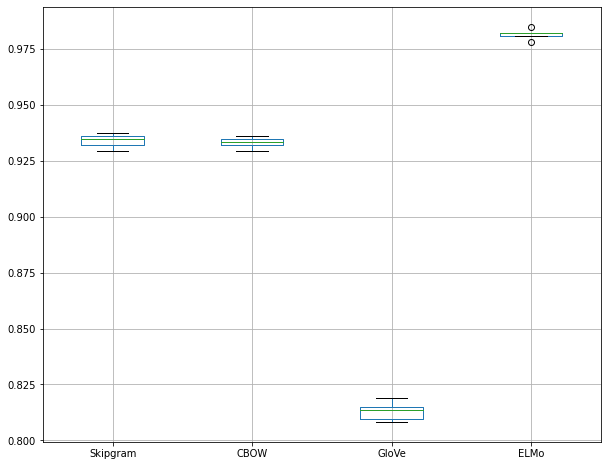

In [59]:
boxplot = accuracy_df.boxplot(figsize=(10,8))